In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
import copy
from pyquaternion import Quaternion

In [3]:
import math

def quaternion_to_euler(w, x, y, z):
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = math.degrees(math.atan2(t0, t1))

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = math.degrees(math.asin(t2))

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = math.degrees(math.atan2(t3, t4))

        return X, Y, Z
    
    
def quaternion_to_euler_2(w, x, y, z):    
    sqw = w*w
    sqx = x*x
    sqy = y*y
    sqz = z*z
    unit = sqx + sqy + sqz + sqw # if normalised is one, otherwise is correction factor
    test = x*y + z*w
    if test > 0.499*unit: # singularity at north pole
        heading = 2 * math.atan2(x,w)
        attitude = math.pi/2
        bank = 0
        return heading, attitude, bank

    if test < -0.499*unit: # singularity at south pole
        heading = -2 * math.atan2(x,w)
        attitude = -math.pi/2
        bank = 0
        return heading, attitude, bank

    heading = math.atan2(2*y*w-2*x*z , sqx - sqy - sqz + sqw)
    attitude = math.asin(2*test/unit)
    bank = math.atan2(2*x*w-2*y*z , -sqx + sqy - sqz + sqw)
    return heading, attitude, bank

In [4]:
mydf = pd.read_csv('C:\IAAA\TER\data\ACORFORMED\Data\N7A\Casque\Unity\N7A-Casque-Unity-out_record_DATE17-2-27_13-29-57.txt', sep='\t')
points_subject = ['HeadSubject', 'LeftWristSubject', 'RightWristSubject', 'LeftElbowSubject', 'RightElbowSubject', 'master']
points_agent = ['Head', 'LeftHand', 'RightHand', 'LeftArm', 'RightArm', 'master']
points = points_subject
df = mydf

In [11]:
all = []
points = points_agent
for point in points:
    all.append(point+'_posx')
    all.append(point+'_posy')
    all.append(point+'_posz')
    all.append(point+'_quax')
    all.append(point+'_quay')
    all.append(point+'_quaz')    
    all.append(point+'_quaw')    
df = mydf.drop_duplicates(subset=all)
print(len(df))

4606


<IPython.core.display.Javascript object>


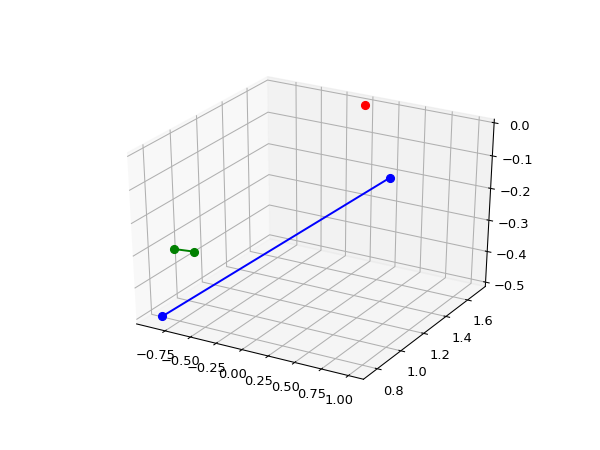

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data = df.iloc[0]

# head
ax.plot([data[points[0]+'_posx']], [data[points[0]+'_posy']], [data[points[0]+'_posz']], linestyle="", marker='o', c='r') 
ax.plot([data[points[1]+'_posx'], data[points[3]+'_posx']], [data[points[1]+'_posy'], data[points[3]+'_posy']], [data[points[1]+'_posz'], data[points[3]+'_posz']], linestyle="-", marker='o', c='b')
ax.plot([data[points[2]+'_posx'], data[points[4]+'_posx']], [data[points[2]+'_posy'], data[points[4]+'_posy']], [data[points[2]+'_posz'], data[points[4]+'_posz']], linestyle="-", marker='o', c='g')

12759


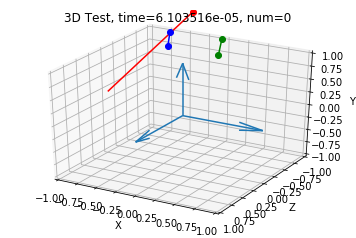

In [5]:
print(len(df))
df = mydf

#a = np.random.rand(2000, 3)*10
#t = np.array([np.ones(100)*i for i in range(20)]).flatten()
#df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
#print(a)
#print(t)
points_subject = ['HeadSubject', 'LeftWristSubject', 'RightWristSubject', 'LeftElbowSubject', 'RightElbowSubject']
points_agent = ['Head', 'LeftHand', 'RightHand', 'LeftArm', 'RightArm']
markers = ['D', 'o', '<', '>', '3', '4', 'x']
colors = ['r', 'orange', 'g', 'g', 'b', 'b', 'black']
graphs = []

points = points_subject
type = 'p'

def vect(v):
    u = copy.copy(v)
    # switch Y and Z axis
    u[1] = v[2]
    u[2] = v[1]
    """if isinstance(v[1], basestring):
        u[2] = v[1]
    else:
        u[2] = -v[1]"""
    return u

def get_quaternion(df, num, point):
    data = df.iloc[num]
    return Quaternion(w=data[point+'_quaw'], x=data[point+'_quax'], y=data[point+'_quay'], z=data[point+'_quaz'])

def get_coords_q(df, num, point):
    data=df.iloc[num]
    v = np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']])
    q = get_quaternion(df, num, point)
    v = q.rotate(v)
    return vect(v)

def get_coords_p(df, num, point):
    data=df.iloc[num]
    #print(np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']]))
    return vect(np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']]))

def get_coords(df, num, point):
    if type == 'p':
        return get_coords_p(df, num, point)
    else:
        return get_coords_q(df, num, point)

def update_graph(num):
    data=df.iloc[num]
    """for idx, point in enumerate(points):
        #x = data[[col+'_posx' for col in points]]
        #y = data[[col+'_posy' for col in points]]
        #z = data[[col+'_posz' for col in points]]
        v = np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']])
        q = Quaternion(x=data[point+'_quax'], y=data[point+'_quay'], z=data[point+'_quaz'], w=data[point+'_quaw'])
        v = q.rotate(v)
        graphs[idx].set_data (v[0], v[1])
        graphs[idx].set_3d_properties(v[2])"""
    v = get_coords(df, num, points[0])
    head.set_data(v[0], v[1])
    head.set_3d_properties(v[2])
    
    q = get_quaternion(df, num, points[0])
    hv = q.rotate([1,0,0])
    head_orientation.set_segments([[ [v[0], v[1], v[2]], [hv[0], hv[1], hv[2]] ]])
    #= ax.quiver(v[0], v[1], v[2], hv[0], hv[1], hv[2], color='r')    
    
    v1 = get_coords(df, num, points[1])
    v2 = get_coords(df, num, points[3])
    left.set_data([v1[0], v2[0]], [v1[1], v2[1]])
    left.set_3d_properties([v1[2], v2[2]])
    v1 = get_coords(df, num, points[2])
    v2 = get_coords(df, num, points[4])
    right.set_data([v1[0], v2[0]], [v1[1], v2[1]])
    right.set_3d_properties([v1[2], v2[2]])
        
    title.set_text('3D Test, time={}, num={}'.format(data['chrono'], num))
    return title, head, left, right


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df.iloc[0]
#df[df['chrono']==0]
#graphs = [ax.plot([data[point+'_posx']], [data[point+'_posy']], [data[point+'_posz']], linestyle="", marker=markers[idx], c=colors[idx])[0] for idx, point in enumerate(points)]

graphs = []
v = get_coords(df, 0, points[0])
head = ax.plot([v[0]], [v[1]], [v[2]], linestyle="", marker='o', c='r')[0]

q = get_quaternion(df, 0, points[0])
hv = q.rotate([1,0,0])
head_orientation = ax.quiver(v[0], v[1], v[2], hv[0], hv[1], hv[2], color='r')


v1 = get_coords(df, 0, points[1])
v2 = get_coords(df, 0, points[3])
left = ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], linestyle="-", marker='o', c='b')[0]
v1 = get_coords(df, 0, points[2])
v2 = get_coords(df, 0, points[4])
right = ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], linestyle="-", marker='o', c='g')[0]




#print(graphs)

#graph, = ax.plot([data[point+'_posx']], [data[point+'_posy']], [data[point+'_posz']], linestyle="", marker="o")
#ax.set_xlim(xmin=df[point+'_posx'].min(), xmax=df[point+'_posx'].max())
#ax.set_ylim(ymin=df[point+'_posy'].min(), ymax=df[point+'_posy'].max())
#ax.set_zlim(zmin=df[point+'_posz'].min(), zmax=df[point+'_posz'].max())
#print(np.amin(df[[col+'_posx' for col in points]].values))

#ax.set_xlim(np.amin(df[[col+'_posx' for col in points]].values), np.amax(df[[col+'_posx' for col in points]].max(axis=None).values))
#ax.set_ylim(np.amin(df[[col+'_posy' for col in points]].values), np.amax(df[[col+'_posy' for col in points]].max(axis=None).values))
#ax.set_zlim(np.amin(df[[col+'_posz' for col in points]].values), np.amax(df[[col+'_posz' for col in points]].max(axis=None).values))

dim = 1
ax.set_xlim(-dim, dim)
ax.set_ylim(dim, -dim)
ax.set_zlim(-dim, dim)
coords = ['X', 'Y', 'Z']
ax.set_xlabel(vect(coords)[0])
ax.set_ylabel(vect(coords)[1])
ax.set_zlabel(vect(coords)[2])

x = [0,0,0]
u = [1,0,0]
v = [0,1,0]
w = [0,0,1]
ax.quiver(x, x, x, vect(u), vect(v), vect(w))

ani = matplotlib.animation.FuncAnimation(fig, update_graph, np.arange(0, len(df), 1), 
                                interval=10, blit=True)

plt.show()

In [6]:
from IPython.core.display import display, HTML
point = 'Head'
#q = [get_quaternion(df, num, point) for num in np.arange(len(df))]


d = df[['chrono', point+'_quax', point+'_quay', point+'_quaz', point+'_quaw']]
d = d.drop_duplicates()
print(len(d))
#display(HTML(d[['HeadSubject_quax', 'HeadSubject_quay', 'HeadSubject_quaz', 'HeadSubject_quaw']].to_html()))
accel = np.zeros((len(df), 3), dtype='float64')
angles = np.zeros((len(df), 3), dtype='float64')
pyaw, ppitch, proll = 0,0,0
for i in np.arange(len(df)):
    q = get_quaternion(d, i, point)
    #print("%f / %s / axis %s angle %f / %f, %f, %f, %f" % (d['chrono'].iloc[i], str(q), str(q.axis), q.angle, d.iloc[i][point+'_quax'], d.iloc[i][point+'_quay'], d.iloc[i][point+'_quaz'], d.iloc[i][point+'_quaw']))
    #x,y,z,w = d.iloc[i]['HeadSubject_quax'], d.iloc[i]['HeadSubject_quay'], d.iloc[i]['HeadSubject_quaz'], d.iloc[i]['HeadSubject_quaw']
    #print("x %f y %f z %f w %f" % (x,y,z,w))
    #q = Quaternion(x,y,z,w)
    #print("axis %s angle %f" % (q.axis, q.angle))
    yaw, pitch, roll = quaternion_to_euler_2(q.w, q.x, q.y, q.z)
    yaw, pitch, roll = abs(yaw), abs(pitch), abs(roll)
    if i == 0:
        pyaw, ppitch, proll = yaw, pitch, roll
    #print('yaw %f pitch %f roll %f' % (yaw, pitch, roll))
    accel[i,:] = [yaw-pyaw, pitch-ppitch, roll-proll]
    angles[i,:] = [yaw, pitch, roll]
    print('yaw %f %f %f' % (pyaw, yaw, yaw-pyaw))
    pyaw, ppitch, proll = yaw,pitch,roll
#print('MEAN %s STD %s' % (str(np.mean(angles, axis=1)), str(np.std(angles, axis=1))))
display(HTML(pd.DataFrame(data=angles, columns=['yaw', 'pitch', 'roll']).describe().to_html()))
display(HTML(pd.DataFrame(data=accel, columns=['yaw a', 'pitch a', 'roll a']).describe().to_html()))
"""a1 = [qua.axis[0] for qua in q]
a2 = [qua.axis[1] for qua in q]
a3 = [qua.axis[2] for qua in q]
angle = [qua.angle for qua in q]
plt.plot(df['chrono'], a1, label='rot x')
plt.plot(df['chrono'], a2, label='rot y')
plt.plot(df['chrono'], a3, label='rot z')
plt.plot(df['chrono'], angle, label='rot angle')"""
#plt.plot(df['chrono'], df[point+'_posx'], label=point+'_posx')
#plt.plot(df['chrono'], df[point+'_posy'], label=point+'_posy')
#plt.plot(df['chrono'], df[point+'_posz'], label=point+'_posz')
"""plt.plot(df['chrono'], angles[:, 0], label='yaw')
plt.legend()
plt.show()"""



12759
yaw 0.407281 0.407281 0.000000
yaw 0.407281 0.407281 0.000000
yaw 0.407281 0.407281 0.000000
yaw 0.407281 0.407773 0.000492
yaw 0.407773 0.407773 0.000000
yaw 0.407773 0.407773 0.000000
yaw 0.407773 0.408330 0.000557
yaw 0.408330 0.408330 0.000000
yaw 0.408330 0.408917 0.000587
yaw 0.408917 0.408917 0.000000
yaw 0.408917 0.408917 0.000000
yaw 0.408917 0.409564 0.000647
yaw 0.409564 0.409564 0.000000
yaw 0.409564 0.409564 0.000000
yaw 0.409564 0.410198 0.000634
yaw 0.410198 0.410198 0.000000
yaw 0.410198 0.410198 0.000000
yaw 0.410198 0.410845 0.000647
yaw 0.410845 0.410845 0.000000
yaw 0.410845 0.410845 0.000000
yaw 0.410845 0.411506 0.000661
yaw 0.411506 0.411506 0.000000
yaw 0.411506 0.412156 0.000650
yaw 0.412156 0.412156 0.000000
yaw 0.412156 0.412156 0.000000
yaw 0.412156 0.412836 0.000680
yaw 0.412836 0.412836 0.000000
yaw 0.412836 0.412836 0.000000
yaw 0.412836 0.413502 0.000666
yaw 0.413502 0.413502 0.000000
yaw 0.413502 0.413502 0.000000
yaw 0.413502 0.414219 0.000717
ya

yaw 0.430093 0.430364 0.000272
yaw 0.430364 0.430364 0.000000
yaw 0.430364 0.430364 0.000000
yaw 0.430364 0.430625 0.000261
yaw 0.430625 0.430625 0.000000
yaw 0.430625 0.430625 0.000000
yaw 0.430625 0.430916 0.000292
yaw 0.430916 0.430916 0.000000
yaw 0.430916 0.431182 0.000265
yaw 0.431182 0.431182 0.000000
yaw 0.431182 0.431182 0.000000
yaw 0.431182 0.431387 0.000205
yaw 0.431387 0.431387 0.000000
yaw 0.431387 0.431387 0.000000
yaw 0.431387 0.431611 0.000224
yaw 0.431611 0.431611 0.000000
yaw 0.431611 0.431611 0.000000
yaw 0.431611 0.431844 0.000233
yaw 0.431844 0.431844 0.000000
yaw 0.431844 0.431844 0.000000
yaw 0.431844 0.432090 0.000246
yaw 0.432090 0.432090 0.000000
yaw 0.432090 0.432354 0.000264
yaw 0.432354 0.432354 0.000000
yaw 0.432354 0.432354 0.000000
yaw 0.432354 0.432628 0.000273
yaw 0.432628 0.432628 0.000000
yaw 0.432628 0.432628 0.000000
yaw 0.432628 0.432876 0.000248
yaw 0.432876 0.432876 0.000000
yaw 0.432876 0.432876 0.000000
yaw 0.432876 0.433126 0.000251
yaw 0.43

yaw 0.427393 0.427393 0.000000
yaw 0.427393 0.427393 0.000000
yaw 0.427393 0.427261 -0.000132
yaw 0.427261 0.427261 0.000000
yaw 0.427261 0.427261 0.000000
yaw 0.427261 0.427065 -0.000196
yaw 0.427065 0.427065 0.000000
yaw 0.427065 0.426821 -0.000244
yaw 0.426821 0.426821 0.000000
yaw 0.426821 0.426821 0.000000
yaw 0.426821 0.426520 -0.000301
yaw 0.426520 0.426520 0.000000
yaw 0.426520 0.426520 0.000000
yaw 0.426520 0.426167 -0.000352
yaw 0.426167 0.426167 0.000000
yaw 0.426167 0.426167 0.000000
yaw 0.426167 0.425756 -0.000412
yaw 0.425756 0.425756 0.000000
yaw 0.425756 0.425756 0.000000
yaw 0.425756 0.425254 -0.000502
yaw 0.425254 0.425254 0.000000
yaw 0.425254 0.424682 -0.000572
yaw 0.424682 0.424682 0.000000
yaw 0.424682 0.424682 0.000000
yaw 0.424682 0.424116 -0.000565
yaw 0.424116 0.424116 0.000000
yaw 0.424116 0.424116 0.000000
yaw 0.424116 0.423472 -0.000644
yaw 0.423472 0.423472 0.000000
yaw 0.423472 0.423472 0.000000
yaw 0.423472 0.422760 -0.000713
yaw 0.422760 0.422760 0.0000

yaw 0.393577 0.391197 -0.002380
yaw 0.391197 0.391197 0.000000
yaw 0.391197 0.391197 0.000000
yaw 0.391197 0.389150 -0.002047
yaw 0.389150 0.389150 0.000000
yaw 0.389150 0.389150 0.000000
yaw 0.389150 0.387371 -0.001779
yaw 0.387371 0.387371 0.000000
yaw 0.387371 0.387371 0.000000
yaw 0.387371 0.385883 -0.001488
yaw 0.385883 0.385883 0.000000
yaw 0.385883 0.384660 -0.001223
yaw 0.384660 0.384660 0.000000
yaw 0.384660 0.384660 0.000000
yaw 0.384660 0.383589 -0.001071
yaw 0.383589 0.383589 0.000000
yaw 0.383589 0.383589 0.000000
yaw 0.383589 0.382833 -0.000756
yaw 0.382833 0.382833 0.000000
yaw 0.382833 0.382833 0.000000
yaw 0.382833 0.382281 -0.000552
yaw 0.382281 0.382281 0.000000
yaw 0.382281 0.382281 0.000000
yaw 0.382281 0.381913 -0.000368
yaw 0.381913 0.381913 0.000000
yaw 0.381913 0.381790 -0.000123
yaw 0.381790 0.381790 0.000000
yaw 0.381790 0.381790 0.000000
yaw 0.381790 0.381687 -0.000103
yaw 0.381687 0.381687 0.000000
yaw 0.381687 0.381687 0.000000
yaw 0.381687 0.381854 0.0001

yaw 0.405926 0.405926 0.000000
yaw 0.405926 0.406347 0.000421
yaw 0.406347 0.406347 0.000000
yaw 0.406347 0.406347 0.000000
yaw 0.406347 0.406347 0.000000
yaw 0.406347 0.406788 0.000441
yaw 0.406788 0.406788 0.000000
yaw 0.406788 0.407274 0.000487
yaw 0.407274 0.407274 0.000000
yaw 0.407274 0.407274 0.000000
yaw 0.407274 0.407795 0.000520
yaw 0.407795 0.407795 0.000000
yaw 0.407795 0.407795 0.000000
yaw 0.407795 0.408341 0.000546
yaw 0.408341 0.408341 0.000000
yaw 0.408341 0.408341 0.000000
yaw 0.408341 0.408951 0.000610
yaw 0.408951 0.408951 0.000000
yaw 0.408951 0.408951 0.000000
yaw 0.408951 0.409604 0.000652
yaw 0.409604 0.409604 0.000000
yaw 0.409604 0.410260 0.000657
yaw 0.410260 0.410260 0.000000
yaw 0.410260 0.410260 0.000000
yaw 0.410260 0.410951 0.000691
yaw 0.410951 0.410951 0.000000
yaw 0.410951 0.410951 0.000000
yaw 0.410951 0.415343 0.004392
yaw 0.415343 0.415343 0.000000
yaw 0.415343 0.415343 0.000000
yaw 0.415343 0.419503 0.004161
yaw 0.419503 0.419503 0.000000
yaw 0.41

yaw 0.403931 0.404335 0.000404
yaw 0.404335 0.404335 0.000000
yaw 0.404335 0.404704 0.000370
yaw 0.404704 0.404704 0.000000
yaw 0.404704 0.404704 0.000000
yaw 0.404704 0.405050 0.000346
yaw 0.405050 0.405050 0.000000
yaw 0.405050 0.405050 0.000000
yaw 0.405050 0.405326 0.000276
yaw 0.405326 0.405326 0.000000
yaw 0.405326 0.405326 0.000000
yaw 0.405326 0.405505 0.000178
yaw 0.405505 0.405505 0.000000
yaw 0.405505 0.405505 0.000000
yaw 0.405505 0.405632 0.000128
yaw 0.405632 0.405632 0.000000
yaw 0.405632 0.405730 0.000098
yaw 0.405730 0.405730 0.000000
yaw 0.405730 0.405730 0.000000
yaw 0.405730 0.405809 0.000079
yaw 0.405809 0.405809 0.000000
yaw 0.405809 0.405809 0.000000
yaw 0.405809 0.405851 0.000042
yaw 0.405851 0.405851 0.000000
yaw 0.405851 0.405851 0.000000
yaw 0.405851 0.405922 0.000071
yaw 0.405922 0.405922 0.000000
yaw 0.405922 0.405922 0.000000
yaw 0.405922 0.405954 0.000031
yaw 0.405954 0.405954 0.000000
yaw 0.405954 0.406000 0.000046
yaw 0.406000 0.406000 0.000000
yaw 0.40

yaw 0.398602 0.398602 0.000000
yaw 0.398602 0.399027 0.000425
yaw 0.399027 0.399027 0.000000
yaw 0.399027 0.399027 0.000000
yaw 0.399027 0.399434 0.000407
yaw 0.399434 0.399434 0.000000
yaw 0.399434 0.399819 0.000385
yaw 0.399819 0.399819 0.000000
yaw 0.399819 0.399819 0.000000
yaw 0.399819 0.400156 0.000337
yaw 0.400156 0.400156 0.000000
yaw 0.400156 0.400156 0.000000
yaw 0.400156 0.400500 0.000344
yaw 0.400500 0.400500 0.000000
yaw 0.400500 0.400500 0.000000
yaw 0.400500 0.400815 0.000315
yaw 0.400815 0.400815 0.000000
yaw 0.400815 0.400815 0.000000
yaw 0.400815 0.401091 0.000276
yaw 0.401091 0.401091 0.000000
yaw 0.401091 0.401344 0.000253
yaw 0.401344 0.401344 0.000000
yaw 0.401344 0.401344 0.000000
yaw 0.401344 0.401575 0.000230
yaw 0.401575 0.401575 0.000000
yaw 0.401575 0.401575 0.000000
yaw 0.401575 0.401792 0.000217
yaw 0.401792 0.401792 0.000000
yaw 0.401792 0.401792 0.000000
yaw 0.401792 0.401998 0.000206
yaw 0.401998 0.401998 0.000000
yaw 0.401998 0.401998 0.000000
yaw 0.40

yaw 0.388540 0.388540 0.000000
yaw 0.388540 0.388540 0.000000
yaw 0.388540 0.388863 0.000322
yaw 0.388863 0.388863 0.000000
yaw 0.388863 0.388863 0.000000
yaw 0.388863 0.389251 0.000389
yaw 0.389251 0.389251 0.000000
yaw 0.389251 0.389251 0.000000
yaw 0.389251 0.389683 0.000431
yaw 0.389683 0.389683 0.000000
yaw 0.389683 0.389683 0.000000
yaw 0.389683 0.390208 0.000525
yaw 0.390208 0.390208 0.000000
yaw 0.390208 0.390712 0.000505
yaw 0.390712 0.390712 0.000000
yaw 0.390712 0.390712 0.000000
yaw 0.390712 0.391186 0.000474
yaw 0.391186 0.391186 0.000000
yaw 0.391186 0.391186 0.000000
yaw 0.391186 0.391589 0.000403
yaw 0.391589 0.391589 0.000000
yaw 0.391589 0.391589 0.000000
yaw 0.391589 0.391918 0.000329
yaw 0.391918 0.391918 0.000000
yaw 0.391918 0.391918 0.000000
yaw 0.391918 0.392197 0.000278
yaw 0.392197 0.392197 0.000000
yaw 0.392197 0.392391 0.000195
yaw 0.392391 0.392391 0.000000
yaw 0.392391 0.392391 0.000000
yaw 0.392391 0.392500 0.000109
yaw 0.392500 0.392500 0.000000
yaw 0.39

yaw 0.397979 0.397979 0.000000
yaw 0.397979 0.398291 0.000311
yaw 0.398291 0.398291 0.000000
yaw 0.398291 0.398291 0.000000
yaw 0.398291 0.398589 0.000298
yaw 0.398589 0.398589 0.000000
yaw 0.398589 0.398589 0.000000
yaw 0.398589 0.398801 0.000213
yaw 0.398801 0.398801 0.000000
yaw 0.398801 0.398801 0.000000
yaw 0.398801 0.398997 0.000195
yaw 0.398997 0.398997 0.000000
yaw 0.398997 0.399136 0.000139
yaw 0.399136 0.399136 0.000000
yaw 0.399136 0.399136 0.000000
yaw 0.399136 0.399230 0.000094
yaw 0.399230 0.399230 0.000000
yaw 0.399230 0.399230 0.000000
yaw 0.399230 0.399306 0.000075
yaw 0.399306 0.399306 0.000000
yaw 0.399306 0.399306 0.000000
yaw 0.399306 0.399272 -0.000034
yaw 0.399272 0.399272 0.000000
yaw 0.399272 0.399272 0.000000
yaw 0.399272 0.399180 -0.000092
yaw 0.399180 0.399180 0.000000
yaw 0.399180 0.399150 -0.000030
yaw 0.399150 0.399150 0.000000
yaw 0.399150 0.399150 0.000000
yaw 0.399150 0.399028 -0.000122
yaw 0.399028 0.399028 0.000000
yaw 0.399028 0.399028 0.000000
yaw 

yaw 0.407729 0.408381 0.000652
yaw 0.408381 0.408381 0.000000
yaw 0.408381 0.408381 0.000000
yaw 0.408381 0.408905 0.000524
yaw 0.408905 0.408905 0.000000
yaw 0.408905 0.408905 0.000000
yaw 0.408905 0.409327 0.000423
yaw 0.409327 0.409327 0.000000
yaw 0.409327 0.409327 0.000000
yaw 0.409327 0.409628 0.000300
yaw 0.409628 0.409628 0.000000
yaw 0.409628 0.409832 0.000204
yaw 0.409832 0.409832 0.000000
yaw 0.409832 0.409832 0.000000
yaw 0.409832 0.409890 0.000058
yaw 0.409890 0.409890 0.000000
yaw 0.409890 0.409890 0.000000
yaw 0.409890 0.409823 -0.000067
yaw 0.409823 0.409823 0.000000
yaw 0.409823 0.409823 0.000000
yaw 0.409823 0.409713 -0.000110
yaw 0.409713 0.409713 0.000000
yaw 0.409713 0.409713 0.000000
yaw 0.409713 0.409535 -0.000179
yaw 0.409535 0.409535 0.000000
yaw 0.409535 0.409365 -0.000170
yaw 0.409365 0.409365 0.000000
yaw 0.409365 0.409365 0.000000
yaw 0.409365 0.409159 -0.000206
yaw 0.409159 0.409159 0.000000
yaw 0.409159 0.409159 0.000000
yaw 0.409159 0.408946 -0.000213
ya

yaw 0.425939 0.427843 0.001904
yaw 0.427843 0.427843 0.000000
yaw 0.427843 0.427843 0.000000
yaw 0.427843 0.429590 0.001747
yaw 0.429590 0.429590 0.000000
yaw 0.429590 0.429590 0.000000
yaw 0.429590 0.431191 0.001602
yaw 0.431191 0.431191 0.000000
yaw 0.431191 0.432651 0.001460
yaw 0.432651 0.432651 0.000000
yaw 0.432651 0.434009 0.001358
yaw 0.434009 0.434009 0.000000
yaw 0.434009 0.435306 0.001297
yaw 0.435306 0.435306 0.000000
yaw 0.435306 0.435306 0.000000
yaw 0.435306 0.436516 0.001210
yaw 0.436516 0.436516 0.000000
yaw 0.436516 0.436516 0.000000
yaw 0.436516 0.437657 0.001141
yaw 0.437657 0.437657 0.000000
yaw 0.437657 0.438760 0.001103
yaw 0.438760 0.438760 0.000000
yaw 0.438760 0.438760 0.000000
yaw 0.438760 0.439842 0.001081
yaw 0.439842 0.439842 0.000000
yaw 0.439842 0.439842 0.000000
yaw 0.439842 0.440889 0.001048
yaw 0.440889 0.440889 0.000000
yaw 0.440889 0.440889 0.000000
yaw 0.440889 0.441906 0.001017
yaw 0.441906 0.441906 0.000000
yaw 0.441906 0.441906 0.000000
yaw 0.44

yaw 0.421531 0.421531 0.000000
yaw 0.421531 0.421504 -0.000027
yaw 0.421504 0.421504 0.000000
yaw 0.421504 0.421504 0.000000
yaw 0.421504 0.421609 0.000104
yaw 0.421609 0.421609 0.000000
yaw 0.421609 0.421609 0.000000
yaw 0.421609 0.421796 0.000187
yaw 0.421796 0.421796 0.000000
yaw 0.421796 0.421796 0.000000
yaw 0.421796 0.422134 0.000338
yaw 0.422134 0.422134 0.000000
yaw 0.422134 0.422134 0.000000
yaw 0.422134 0.422555 0.000421
yaw 0.422555 0.422555 0.000000
yaw 0.422555 0.422998 0.000443
yaw 0.422998 0.422998 0.000000
yaw 0.422998 0.422998 0.000000
yaw 0.422998 0.423350 0.000352
yaw 0.423350 0.423350 0.000000
yaw 0.423350 0.423350 0.000000
yaw 0.423350 0.423675 0.000325
yaw 0.423675 0.423675 0.000000
yaw 0.423675 0.423675 0.000000
yaw 0.423675 0.424003 0.000328
yaw 0.424003 0.424003 0.000000
yaw 0.424003 0.424003 0.000000
yaw 0.424003 0.424298 0.000294
yaw 0.424298 0.424298 0.000000
yaw 0.424298 0.424619 0.000321
yaw 0.424619 0.424619 0.000000
yaw 0.424619 0.424619 0.000000
yaw 0.4

yaw 0.430816 0.430816 0.000000
yaw 0.430816 0.430816 0.000000
yaw 0.430816 0.429545 -0.001271
yaw 0.429545 0.429545 0.000000
yaw 0.429545 0.429545 0.000000
yaw 0.429545 0.428271 -0.001274
yaw 0.428271 0.428271 0.000000
yaw 0.428271 0.426992 -0.001278
yaw 0.426992 0.426992 0.000000
yaw 0.426992 0.426992 0.000000
yaw 0.426992 0.425683 -0.001309
yaw 0.425683 0.425683 0.000000
yaw 0.425683 0.425683 0.000000
yaw 0.425683 0.424398 -0.001285
yaw 0.424398 0.424398 0.000000
yaw 0.424398 0.424398 0.000000
yaw 0.424398 0.423134 -0.001263
yaw 0.423134 0.423134 0.000000
yaw 0.423134 0.423134 0.000000
yaw 0.423134 0.421979 -0.001156
yaw 0.421979 0.421979 0.000000
yaw 0.421979 0.420887 -0.001091
yaw 0.420887 0.420887 0.000000
yaw 0.420887 0.420887 0.000000
yaw 0.420887 0.419891 -0.000996
yaw 0.419891 0.419891 0.000000
yaw 0.419891 0.419891 0.000000
yaw 0.419891 0.418934 -0.000957
yaw 0.418934 0.418934 0.000000
yaw 0.418934 0.418934 0.000000
yaw 0.418934 0.418062 -0.000872
yaw 0.418062 0.418062 0.0000

yaw 0.427916 0.427916 0.000000
yaw 0.427916 0.427323 -0.000593
yaw 0.427323 0.427323 0.000000
yaw 0.427323 0.427323 0.000000
yaw 0.427323 0.426554 -0.000769
yaw 0.426554 0.426554 0.000000
yaw 0.426554 0.425647 -0.000906
yaw 0.425647 0.425647 0.000000
yaw 0.425647 0.425647 0.000000
yaw 0.425647 0.424605 -0.001043
yaw 0.424605 0.424605 0.000000
yaw 0.424605 0.424605 0.000000
yaw 0.424605 0.423470 -0.001134
yaw 0.423470 0.423470 0.000000
yaw 0.423470 0.423470 0.000000
yaw 0.423470 0.422297 -0.001174
yaw 0.422297 0.422297 0.000000
yaw 0.422297 0.422297 0.000000
yaw 0.422297 0.421162 -0.001135
yaw 0.421162 0.421162 0.000000
yaw 0.421162 0.420030 -0.001133
yaw 0.420030 0.420030 0.000000
yaw 0.420030 0.420030 0.000000
yaw 0.420030 0.418916 -0.001113
yaw 0.418916 0.418916 0.000000
yaw 0.418916 0.418916 0.000000
yaw 0.418916 0.417754 -0.001162
yaw 0.417754 0.417754 0.000000
yaw 0.417754 0.417754 0.000000
yaw 0.417754 0.416497 -0.001257
yaw 0.416497 0.416497 0.000000
yaw 0.416497 0.416497 0.0000

yaw 0.404449 0.404449 0.000000
yaw 0.404449 0.404449 0.000000
yaw 0.404449 0.404702 0.000253
yaw 0.404702 0.404702 0.000000
yaw 0.404702 0.404702 0.000000
yaw 0.404702 0.405163 0.000461
yaw 0.405163 0.405163 0.000000
yaw 0.405163 0.405780 0.000617
yaw 0.405780 0.405780 0.000000
yaw 0.405780 0.405780 0.000000
yaw 0.405780 0.406590 0.000810
yaw 0.406590 0.406590 0.000000
yaw 0.406590 0.406590 0.000000
yaw 0.406590 0.407545 0.000954
yaw 0.407545 0.407545 0.000000
yaw 0.407545 0.407545 0.000000
yaw 0.407545 0.408567 0.001023
yaw 0.408567 0.408567 0.000000
yaw 0.408567 0.408567 0.000000
yaw 0.408567 0.409599 0.001032
yaw 0.409599 0.409599 0.000000
yaw 0.409599 0.410667 0.001068
yaw 0.410667 0.410667 0.000000
yaw 0.410667 0.410667 0.000000
yaw 0.410667 0.411773 0.001105
yaw 0.411773 0.411773 0.000000
yaw 0.411773 0.411773 0.000000
yaw 0.411773 0.412867 0.001094
yaw 0.412867 0.412867 0.000000
yaw 0.412867 0.412867 0.000000
yaw 0.412867 0.413989 0.001123
yaw 0.413989 0.413989 0.000000
yaw 0.41

yaw 0.421188 0.421188 0.000000
yaw 0.421188 0.421188 0.000000
yaw 0.421188 0.421588 0.000400
yaw 0.421588 0.421588 0.000000
yaw 0.421588 0.421588 0.000000
yaw 0.421588 0.421961 0.000372
yaw 0.421961 0.421961 0.000000
yaw 0.421961 0.422346 0.000385
yaw 0.422346 0.422346 0.000000
yaw 0.422346 0.422346 0.000000
yaw 0.422346 0.422726 0.000380
yaw 0.422726 0.422726 0.000000
yaw 0.422726 0.422726 0.000000
yaw 0.422726 0.423051 0.000325
yaw 0.423051 0.423051 0.000000
yaw 0.423051 0.423051 0.000000
yaw 0.423051 0.423406 0.000355
yaw 0.423406 0.423406 0.000000
yaw 0.423406 0.423406 0.000000
yaw 0.423406 0.423704 0.000298
yaw 0.423704 0.423704 0.000000
yaw 0.423704 0.423930 0.000226
yaw 0.423930 0.423930 0.000000
yaw 0.423930 0.423930 0.000000
yaw 0.423930 0.424108 0.000178
yaw 0.424108 0.424108 0.000000
yaw 0.424108 0.424108 0.000000
yaw 0.424108 0.424211 0.000102
yaw 0.424211 0.424211 0.000000
yaw 0.424211 0.424211 0.000000
yaw 0.424211 0.424321 0.000110
yaw 0.424321 0.424321 0.000000
yaw 0.42

yaw 0.419038 0.419038 0.000000
yaw 0.419038 0.419710 0.000671
yaw 0.419710 0.419710 0.000000
yaw 0.419710 0.419710 0.000000
yaw 0.419710 0.420365 0.000655
yaw 0.420365 0.420365 0.000000
yaw 0.420365 0.420365 0.000000
yaw 0.420365 0.420994 0.000629
yaw 0.420994 0.420994 0.000000
yaw 0.420994 0.420994 0.000000
yaw 0.420994 0.421616 0.000623
yaw 0.421616 0.421616 0.000000
yaw 0.421616 0.421616 0.000000
yaw 0.421616 0.422209 0.000592
yaw 0.422209 0.422209 0.000000
yaw 0.422209 0.422771 0.000562
yaw 0.422771 0.422771 0.000000
yaw 0.422771 0.422771 0.000000
yaw 0.422771 0.423303 0.000532
yaw 0.423303 0.423303 0.000000
yaw 0.423303 0.423303 0.000000
yaw 0.423303 0.423834 0.000531
yaw 0.423834 0.423834 0.000000
yaw 0.423834 0.423834 0.000000
yaw 0.423834 0.424319 0.000486
yaw 0.424319 0.424319 0.000000
yaw 0.424319 0.424319 0.000000
yaw 0.424319 0.424783 0.000464
yaw 0.424783 0.424783 0.000000
yaw 0.424783 0.425210 0.000427
yaw 0.425210 0.425210 0.000000
yaw 0.425210 0.425637 0.000427
yaw 0.42

yaw 0.434055 0.434055 0.000000
yaw 0.434055 0.434055 0.000000
yaw 0.434055 0.434029 -0.000025
yaw 0.434029 0.434029 0.000000
yaw 0.434029 0.433951 -0.000078
yaw 0.433951 0.433951 0.000000
yaw 0.433951 0.433951 0.000000
yaw 0.433951 0.433808 -0.000143
yaw 0.433808 0.433808 0.000000
yaw 0.433808 0.433808 0.000000
yaw 0.433808 0.433626 -0.000183
yaw 0.433626 0.433626 0.000000
yaw 0.433626 0.433626 0.000000
yaw 0.433626 0.433391 -0.000235
yaw 0.433391 0.433391 0.000000
yaw 0.433391 0.433391 0.000000
yaw 0.433391 0.433084 -0.000307
yaw 0.433084 0.433084 0.000000
yaw 0.433084 0.432713 -0.000371
yaw 0.432713 0.432713 0.000000
yaw 0.432713 0.432713 0.000000
yaw 0.432713 0.432232 -0.000481
yaw 0.432232 0.432232 0.000000
yaw 0.432232 0.432232 0.000000
yaw 0.432232 0.431686 -0.000546
yaw 0.431686 0.431686 0.000000
yaw 0.431686 0.431686 0.000000
yaw 0.431686 0.431083 -0.000604
yaw 0.431083 0.431083 0.000000
yaw 0.431083 0.431083 0.000000
yaw 0.431083 0.430528 -0.000554
yaw 0.430528 0.430528 0.0000

yaw 0.412424 0.412424 0.000000
yaw 0.412424 0.411877 -0.000547
yaw 0.411877 0.411877 0.000000
yaw 0.411877 0.411877 0.000000
yaw 0.411877 0.411434 -0.000444
yaw 0.411434 0.411434 0.000000
yaw 0.411434 0.411434 0.000000
yaw 0.411434 0.411091 -0.000343
yaw 0.411091 0.411091 0.000000
yaw 0.411091 0.411091 0.000000
yaw 0.411091 0.410826 -0.000265
yaw 0.410826 0.410826 0.000000
yaw 0.410826 0.410627 -0.000199
yaw 0.410627 0.410627 0.000000
yaw 0.410627 0.410627 0.000000
yaw 0.410627 0.410442 -0.000186
yaw 0.410442 0.410442 0.000000
yaw 0.410442 0.410442 0.000000
yaw 0.410442 0.410283 -0.000159
yaw 0.410283 0.410283 0.000000
yaw 0.410283 0.410283 0.000000
yaw 0.410283 0.410059 -0.000223
yaw 0.410059 0.410059 0.000000
yaw 0.410059 0.410059 0.000000
yaw 0.410059 0.409757 -0.000302
yaw 0.409757 0.409757 0.000000
yaw 0.409757 0.409430 -0.000327
yaw 0.409430 0.409430 0.000000
yaw 0.409430 0.409430 0.000000
yaw 0.409430 0.409062 -0.000369
yaw 0.409062 0.409062 0.000000
yaw 0.409062 0.409062 0.0000

yaw 0.403694 0.403694 0.000000
yaw 0.403694 0.403694 0.000000
yaw 0.403694 0.403150 -0.000544
yaw 0.403150 0.403150 0.000000
yaw 0.403150 0.403150 0.000000
yaw 0.403150 0.402679 -0.000471
yaw 0.402679 0.402679 0.000000
yaw 0.402679 0.402679 0.000000
yaw 0.402679 0.402268 -0.000410
yaw 0.402268 0.402268 0.000000
yaw 0.402268 0.402268 0.000000
yaw 0.402268 0.401896 -0.000372
yaw 0.401896 0.401896 0.000000
yaw 0.401896 0.401600 -0.000296
yaw 0.401600 0.401600 0.000000
yaw 0.401600 0.401600 0.000000
yaw 0.401600 0.401325 -0.000274
yaw 0.401325 0.401325 0.000000
yaw 0.401325 0.401325 0.000000
yaw 0.401325 0.401085 -0.000240
yaw 0.401085 0.401085 0.000000
yaw 0.401085 0.401085 0.000000
yaw 0.401085 0.400902 -0.000183
yaw 0.400902 0.400902 0.000000
yaw 0.400902 0.400902 0.000000
yaw 0.400902 0.400744 -0.000158
yaw 0.400744 0.400744 0.000000
yaw 0.400744 0.400620 -0.000125
yaw 0.400620 0.400620 0.000000
yaw 0.400620 0.400620 0.000000
yaw 0.400620 0.400546 -0.000073
yaw 0.400546 0.400546 0.0000

yaw 0.412261 0.411850 -0.000411
yaw 0.411850 0.411850 0.000000
yaw 0.411850 0.411850 0.000000
yaw 0.411850 0.411452 -0.000398
yaw 0.411452 0.411452 0.000000
yaw 0.411452 0.411452 0.000000
yaw 0.411452 0.411069 -0.000383
yaw 0.411069 0.411069 0.000000
yaw 0.411069 0.411069 0.000000
yaw 0.411069 0.410717 -0.000353
yaw 0.410717 0.410717 0.000000
yaw 0.410717 0.410717 0.000000
yaw 0.410717 0.410333 -0.000383
yaw 0.410333 0.410333 0.000000
yaw 0.410333 0.409995 -0.000338
yaw 0.409995 0.409995 0.000000
yaw 0.409995 0.409995 0.000000
yaw 0.409995 0.409713 -0.000282
yaw 0.409713 0.409713 0.000000
yaw 0.409713 0.409713 0.000000
yaw 0.409713 0.409477 -0.000236
yaw 0.409477 0.409477 0.000000
yaw 0.409477 0.409477 0.000000
yaw 0.409477 0.409264 -0.000213
yaw 0.409264 0.409264 0.000000
yaw 0.409264 0.409264 0.000000
yaw 0.409264 0.409146 -0.000117
yaw 0.409146 0.409146 0.000000
yaw 0.409146 0.409062 -0.000085
yaw 0.409062 0.409062 0.000000
yaw 0.409062 0.409062 0.000000
yaw 0.409062 0.409091 0.0000

yaw 0.410750 0.409429 -0.001321
yaw 0.409429 0.409429 0.000000
yaw 0.409429 0.409429 0.000000
yaw 0.409429 0.407958 -0.001471
yaw 0.407958 0.407958 0.000000
yaw 0.407958 0.407958 0.000000
yaw 0.407958 0.406509 -0.001449
yaw 0.406509 0.406509 0.000000
yaw 0.406509 0.406509 0.000000
yaw 0.406509 0.405099 -0.001410
yaw 0.405099 0.405099 0.000000
yaw 0.405099 0.405099 0.000000
yaw 0.405099 0.403741 -0.001358
yaw 0.403741 0.403741 0.000000
yaw 0.403741 0.402426 -0.001314
yaw 0.402426 0.402426 0.000000
yaw 0.402426 0.402426 0.000000
yaw 0.402426 0.401179 -0.001247
yaw 0.401179 0.401179 0.000000
yaw 0.401179 0.401179 0.000000
yaw 0.401179 0.399985 -0.001194
yaw 0.399985 0.399985 0.000000
yaw 0.399985 0.399985 0.000000
yaw 0.399985 0.398836 -0.001149
yaw 0.398836 0.398836 0.000000
yaw 0.398836 0.398836 0.000000
yaw 0.398836 0.397777 -0.001059
yaw 0.397777 0.397777 0.000000
yaw 0.397777 0.396799 -0.000977
yaw 0.396799 0.396799 0.000000
yaw 0.396799 0.396799 0.000000
yaw 0.396799 0.395921 -0.000

yaw 0.417028 0.417071 0.000043
yaw 0.417071 0.417071 0.000000
yaw 0.417071 0.417071 0.000000
yaw 0.417071 0.417077 0.000006
yaw 0.417077 0.417077 0.000000
yaw 0.417077 0.417065 -0.000011
yaw 0.417065 0.417065 0.000000
yaw 0.417065 0.417065 0.000000
yaw 0.417065 0.417013 -0.000053
yaw 0.417013 0.417013 0.000000
yaw 0.417013 0.416939 -0.000073
yaw 0.416939 0.416939 0.000000
yaw 0.416939 0.416939 0.000000
yaw 0.416939 0.416851 -0.000088
yaw 0.416851 0.416851 0.000000
yaw 0.416851 0.416851 0.000000
yaw 0.416851 0.416710 -0.000140
yaw 0.416710 0.416710 0.000000
yaw 0.416710 0.416546 -0.000164
yaw 0.416546 0.416546 0.000000
yaw 0.416546 0.416546 0.000000
yaw 0.416546 0.416319 -0.000227
yaw 0.416319 0.416319 0.000000
yaw 0.416319 0.416061 -0.000258
yaw 0.416061 0.416061 0.000000
yaw 0.416061 0.416061 0.000000
yaw 0.416061 0.415756 -0.000305
yaw 0.415756 0.415756 0.000000
yaw 0.415756 0.415756 0.000000
yaw 0.415756 0.415448 -0.000308
yaw 0.415448 0.415448 0.000000
yaw 0.415448 0.415103 -0.0003

yaw 0.421729 0.421729 0.000000
yaw 0.421729 0.421729 0.000000
yaw 0.421729 0.421670 -0.000059
yaw 0.421670 0.421670 0.000000
yaw 0.421670 0.421670 0.000000
yaw 0.421670 0.421602 -0.000068
yaw 0.421602 0.421602 0.000000
yaw 0.421602 0.421494 -0.000109
yaw 0.421494 0.421494 0.000000
yaw 0.421494 0.421494 0.000000
yaw 0.421494 0.421429 -0.000065
yaw 0.421429 0.421429 0.000000
yaw 0.421429 0.421429 0.000000
yaw 0.421429 0.421345 -0.000083
yaw 0.421345 0.421345 0.000000
yaw 0.421345 0.421277 -0.000069
yaw 0.421277 0.421277 0.000000
yaw 0.421277 0.421277 0.000000
yaw 0.421277 0.421103 -0.000174
yaw 0.421103 0.421103 0.000000
yaw 0.421103 0.420936 -0.000167
yaw 0.420936 0.420936 0.000000
yaw 0.420936 0.420936 0.000000
yaw 0.420936 0.420827 -0.000109
yaw 0.420827 0.420827 0.000000
yaw 0.420827 0.420827 0.000000
yaw 0.420827 0.420706 -0.000121
yaw 0.420706 0.420706 0.000000
yaw 0.420706 0.420706 0.000000
yaw 0.420706 0.420596 -0.000110
yaw 0.420596 0.420596 0.000000
yaw 0.420596 0.420596 0.0000

yaw 0.431127 0.430053 -0.001074
yaw 0.430053 0.430053 0.000000
yaw 0.430053 0.430053 0.000000
yaw 0.430053 0.428980 -0.001073
yaw 0.428980 0.428980 0.000000
yaw 0.428980 0.428980 0.000000
yaw 0.428980 0.427946 -0.001034
yaw 0.427946 0.427946 0.000000
yaw 0.427946 0.427946 0.000000
yaw 0.427946 0.426995 -0.000951
yaw 0.426995 0.426995 0.000000
yaw 0.426995 0.426995 0.000000
yaw 0.426995 0.425974 -0.001021
yaw 0.425974 0.425974 0.000000
yaw 0.425974 0.425028 -0.000946
yaw 0.425028 0.425028 0.000000
yaw 0.425028 0.425028 0.000000
yaw 0.425028 0.424147 -0.000881
yaw 0.424147 0.424147 0.000000
yaw 0.424147 0.424147 0.000000
yaw 0.424147 0.423377 -0.000770
yaw 0.423377 0.423377 0.000000
yaw 0.423377 0.423377 0.000000
yaw 0.423377 0.422730 -0.000647
yaw 0.422730 0.422730 0.000000
yaw 0.422730 0.422730 0.000000
yaw 0.422730 0.422235 -0.000494
yaw 0.422235 0.422235 0.000000
yaw 0.422235 0.421834 -0.000401
yaw 0.421834 0.421834 0.000000
yaw 0.421834 0.421834 0.000000
yaw 0.421834 0.421522 -0.000

yaw 0.426531 0.426531 0.000000
yaw 0.426531 0.426531 0.000000
yaw 0.426531 0.427722 0.001192
yaw 0.427722 0.427722 0.000000
yaw 0.427722 0.428847 0.001125
yaw 0.428847 0.428847 0.000000
yaw 0.428847 0.428847 0.000000
yaw 0.428847 0.429819 0.000972
yaw 0.429819 0.429819 0.000000
yaw 0.429819 0.429819 0.000000
yaw 0.429819 0.430682 0.000863
yaw 0.430682 0.430682 0.000000
yaw 0.430682 0.430682 0.000000
yaw 0.430682 0.431499 0.000817
yaw 0.431499 0.431499 0.000000
yaw 0.431499 0.431499 0.000000
yaw 0.431499 0.432254 0.000755
yaw 0.432254 0.432254 0.000000
yaw 0.432254 0.433002 0.000748
yaw 0.433002 0.433002 0.000000
yaw 0.433002 0.433002 0.000000
yaw 0.433002 0.433804 0.000801
yaw 0.433804 0.433804 0.000000
yaw 0.433804 0.433804 0.000000
yaw 0.433804 0.434612 0.000808
yaw 0.434612 0.434612 0.000000
yaw 0.434612 0.434612 0.000000
yaw 0.434612 0.435500 0.000888
yaw 0.435500 0.435500 0.000000
yaw 0.435500 0.435500 0.000000
yaw 0.435500 0.436425 0.000926
yaw 0.436425 0.436425 0.000000
yaw 0.43

yaw 0.445620 0.445620 0.000000
yaw 0.445620 0.445620 0.000000
yaw 0.445620 0.445198 -0.000422
yaw 0.445198 0.445198 0.000000
yaw 0.445198 0.445198 0.000000
yaw 0.445198 0.444693 -0.000505
yaw 0.444693 0.444693 0.000000
yaw 0.444693 0.444693 0.000000
yaw 0.444693 0.444116 -0.000577
yaw 0.444116 0.444116 0.000000
yaw 0.444116 0.444116 0.000000
yaw 0.444116 0.443408 -0.000708
yaw 0.443408 0.443408 0.000000
yaw 0.443408 0.442679 -0.000729
yaw 0.442679 0.442679 0.000000
yaw 0.442679 0.442679 0.000000
yaw 0.442679 0.441908 -0.000771
yaw 0.441908 0.441908 0.000000
yaw 0.441908 0.441908 0.000000
yaw 0.441908 0.441115 -0.000793
yaw 0.441115 0.441115 0.000000
yaw 0.441115 0.441115 0.000000
yaw 0.441115 0.440309 -0.000806
yaw 0.440309 0.440309 0.000000
yaw 0.440309 0.440309 0.000000
yaw 0.440309 0.439619 -0.000690
yaw 0.439619 0.439619 0.000000
yaw 0.439619 0.438893 -0.000727
yaw 0.438893 0.438893 0.000000
yaw 0.438893 0.438893 0.000000
yaw 0.438893 0.438130 -0.000763
yaw 0.438130 0.438130 0.0000

yaw 0.432920 0.433392 0.000472
yaw 0.433392 0.433392 0.000000
yaw 0.433392 0.433392 0.000000
yaw 0.433392 0.433865 0.000473
yaw 0.433865 0.433865 0.000000
yaw 0.433865 0.434332 0.000467
yaw 0.434332 0.434332 0.000000
yaw 0.434332 0.434332 0.000000
yaw 0.434332 0.434332 0.000000
yaw 0.434332 0.434780 0.000448
yaw 0.434780 0.434780 0.000000
yaw 0.434780 0.434780 0.000000
yaw 0.434780 0.435206 0.000426
yaw 0.435206 0.435206 0.000000
yaw 0.435206 0.435588 0.000382
yaw 0.435588 0.435588 0.000000
yaw 0.435588 0.435588 0.000000
yaw 0.435588 0.435954 0.000365
yaw 0.435954 0.435954 0.000000
yaw 0.435954 0.436277 0.000323
yaw 0.436277 0.436277 0.000000
yaw 0.436277 0.436277 0.000000
yaw 0.436277 0.436579 0.000303
yaw 0.436579 0.436579 0.000000
yaw 0.436579 0.436579 0.000000
yaw 0.436579 0.436807 0.000228
yaw 0.436807 0.436807 0.000000
yaw 0.436807 0.436976 0.000169
yaw 0.436976 0.436976 0.000000
yaw 0.436976 0.436976 0.000000
yaw 0.436976 0.437099 0.000123
yaw 0.437099 0.437099 0.000000
yaw 0.43

yaw 0.458554 0.458444 -0.000110
yaw 0.458444 0.458444 0.000000
yaw 0.458444 0.458230 -0.000214
yaw 0.458230 0.458230 0.000000
yaw 0.458230 0.458230 0.000000
yaw 0.458230 0.457910 -0.000320
yaw 0.457910 0.457910 0.000000
yaw 0.457910 0.457484 -0.000426
yaw 0.457484 0.457484 0.000000
yaw 0.457484 0.457484 0.000000
yaw 0.457484 0.456959 -0.000525
yaw 0.456959 0.456959 0.000000
yaw 0.456959 0.456959 0.000000
yaw 0.456959 0.456350 -0.000609
yaw 0.456350 0.456350 0.000000
yaw 0.456350 0.455661 -0.000690
yaw 0.455661 0.455661 0.000000
yaw 0.455661 0.455661 0.000000
yaw 0.455661 0.454884 -0.000777
yaw 0.454884 0.454884 0.000000
yaw 0.454884 0.454030 -0.000853
yaw 0.454030 0.454030 0.000000
yaw 0.454030 0.454030 0.000000
yaw 0.454030 0.453278 -0.000752
yaw 0.453278 0.453278 0.000000
yaw 0.453278 0.453278 0.000000
yaw 0.453278 0.452268 -0.001010
yaw 0.452268 0.452268 0.000000
yaw 0.452268 0.451274 -0.000995
yaw 0.451274 0.451274 0.000000
yaw 0.451274 0.451274 0.000000
yaw 0.451274 0.450228 -0.00

yaw 0.446437 0.445961 -0.000477
yaw 0.445961 0.445961 0.000000
yaw 0.445961 0.445410 -0.000551
yaw 0.445410 0.445410 0.000000
yaw 0.445410 0.445410 0.000000
yaw 0.445410 0.444883 -0.000527
yaw 0.444883 0.444883 0.000000
yaw 0.444883 0.444402 -0.000481
yaw 0.444402 0.444402 0.000000
yaw 0.444402 0.444402 0.000000
yaw 0.444402 0.443891 -0.000510
yaw 0.443891 0.443891 0.000000
yaw 0.443891 0.443891 0.000000
yaw 0.443891 0.443352 -0.000539
yaw 0.443352 0.443352 0.000000
yaw 0.443352 0.442809 -0.000544
yaw 0.442809 0.442809 0.000000
yaw 0.442809 0.442809 0.000000
yaw 0.442809 0.442259 -0.000549
yaw 0.442259 0.442259 0.000000
yaw 0.442259 0.441755 -0.000505
yaw 0.441755 0.441755 0.000000
yaw 0.441755 0.441755 0.000000
yaw 0.441755 0.441294 -0.000461
yaw 0.441294 0.441294 0.000000
yaw 0.441294 0.441294 0.000000
yaw 0.441294 0.440838 -0.000456
yaw 0.440838 0.440838 0.000000
yaw 0.440838 0.440362 -0.000476
yaw 0.440362 0.440362 0.000000
yaw 0.440362 0.440362 0.000000
yaw 0.440362 0.439924 -0.00

yaw 0.432734 0.432734 0.000000
yaw 0.432734 0.432734 0.000000
yaw 0.432734 0.431899 -0.000835
yaw 0.431899 0.431899 0.000000
yaw 0.431899 0.431026 -0.000873
yaw 0.431026 0.431026 0.000000
yaw 0.431026 0.431026 0.000000
yaw 0.431026 0.430181 -0.000845
yaw 0.430181 0.430181 0.000000
yaw 0.430181 0.430181 0.000000
yaw 0.430181 0.429309 -0.000872
yaw 0.429309 0.429309 0.000000
yaw 0.429309 0.429309 0.000000
yaw 0.429309 0.428371 -0.000937
yaw 0.428371 0.428371 0.000000
yaw 0.428371 0.428371 0.000000
yaw 0.428371 0.427407 -0.000964
yaw 0.427407 0.427407 0.000000
yaw 0.427407 0.426363 -0.001045
yaw 0.426363 0.426363 0.000000
yaw 0.426363 0.426363 0.000000
yaw 0.426363 0.425385 -0.000977
yaw 0.425385 0.425385 0.000000
yaw 0.425385 0.425385 0.000000
yaw 0.425385 0.424158 -0.001227
yaw 0.424158 0.424158 0.000000
yaw 0.424158 0.422822 -0.001336
yaw 0.422822 0.422822 0.000000
yaw 0.422822 0.422822 0.000000
yaw 0.422822 0.421396 -0.001426
yaw 0.421396 0.421396 0.000000
yaw 0.421396 0.419866 -0.001

,yaw,pitch,roll
count,12759.000000,1.275900e+04,12759.000000
mean,0.418498,9.284570e-03,0.073887
std,0.016061,7.455678e-03,0.066998
min,0.380515,2.612492e-07,0.000017
25%,0.406943,3.132335e-03,0.015251
50%,0.417512,7.620550e-03,0.038385
75%,0.430485,1.373110e-02,0.121366
max,0.460261,3.394970e-02,0.225330


,yaw a,pitch a,roll a
count,1.275900e+04,1.275900e+04,12759.000000
mean,-5.491904e-07,4.355425e-07,0.000006
std,4.397269e-04,1.688829e-04,0.000676
min,-3.362394e-03,-1.172007e-03,-0.005538
25%,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,0.000000e+00,0.000000
75%,0.000000e+00,0.000000e+00,0.000000
max,4.391687e-03,1.263086e-03,0.006864


"plt.plot(df['chrono'], angles[:, 0], label='yaw')\nplt.legend()\nplt.show()"

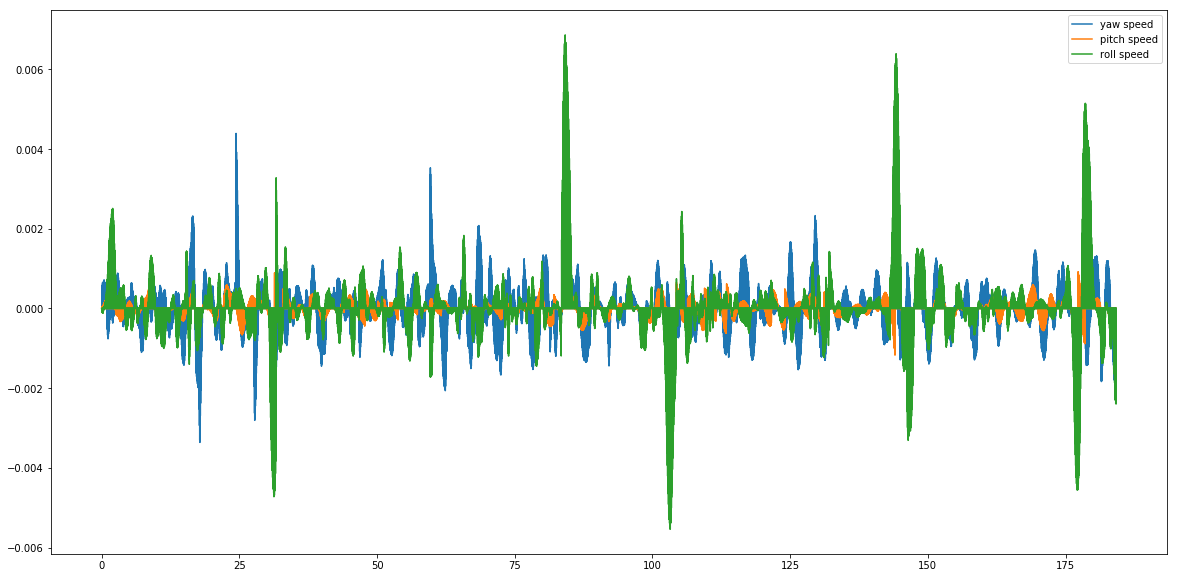

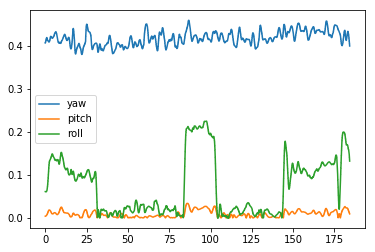

In [7]:
plt.figure(figsize=(20,10))
plt.plot(df['chrono'], accel[:, 0], label='yaw speed')
plt.plot(df['chrono'], accel[:, 1], label='pitch speed')
plt.plot(df['chrono'], accel[:, 2], label='roll speed')
plt.legend()
plt.show()

plt.plot(df['chrono'], angles[:, 0], label='yaw')
plt.plot(df['chrono'], angles[:, 1], label='pitch')
plt.plot(df['chrono'], angles[:, 2], label='roll')
plt.legend()
plt.show()

In [45]:
means =np.mean(accel, axis=0)
stds = np.std(accel, axis=0)
arr = np.hstack([means, stds])
print(arr)
labels = ['AvgYaw', 'AvgPitch', 'AvgRoll', 'StdYaw', 'StdPitch', 'StdRoll']
pd.DataFrame(data=arr, index=labels).T
print(df['chrono'].values[-1])

[-9.53433354e-07  1.46801092e-05 -4.85927427e-06  7.42494060e-04
  1.08958879e-03  3.90128719e-04]
184.1963


In [82]:
stds = df.var(axis=0)
match_cols = sorted(list(stds[stds > 10E-10].index))
print([col for col in match_cols if 'Subject' not in col and '_qua' in col])


['Head_quaw', 'Head_quax', 'Head_quay', 'Head_quaz', 'Jaw_quaw', 'Jaw_quay', 'LeftArmRoll_quaw', 'LeftArmRoll_quax', 'LeftArmRoll_quay', 'LeftArmRoll_quaz', 'LeftArm_quaw', 'LeftArm_quax', 'LeftArm_quay', 'LeftArm_quaz', 'LeftEye_quaw', 'LeftEye_quax', 'LeftEye_quay', 'LeftEye_quaz', 'LeftForeArmRoll_quaw', 'LeftForeArmRoll_quax', 'LeftForeArmRoll_quay', 'LeftForeArmRoll_quaz', 'LeftForeArm_quaw', 'LeftForeArm_quax', 'LeftForeArm_quay', 'LeftForeArm_quaz', 'LeftHandIndex1_quaw', 'LeftHandIndex1_quax', 'LeftHandIndex1_quay', 'LeftHandIndex1_quaz', 'LeftHandIndex2_quaw', 'LeftHandIndex2_quax', 'LeftHandIndex2_quay', 'LeftHandIndex2_quaz', 'LeftHandIndex3_quaw', 'LeftHandIndex3_quax', 'LeftHandIndex3_quay', 'LeftHandIndex3_quaz', 'LeftHandMiddle1_quaw', 'LeftHandMiddle1_quax', 'LeftHandMiddle1_quay', 'LeftHandMiddle1_quaz', 'LeftHandMiddle2_quaw', 'LeftHandMiddle2_quax', 'LeftHandMiddle2_quay', 'LeftHandMiddle2_quaz', 'LeftHandMiddle3_quaw', 'LeftHandMiddle3_quax', 'LeftHandMiddle3_quay',

In [ ]:
print(df.iloc[10]['chrono'])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

def update_graph(num):
    data=df[df['time']==num]
    print(data.shape)
    print(data.x.shape)
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=True)

plt.show()

In [ ]:
data=df[df['time']==0]
data.x

In [12]:
import numpy as np
from pyquaternion import Quaternion

np.set_printoptions(suppress=True) # Suppress insignificant values for clarity
v = np.array([0., 0., 1.]) # Unit vector in the +z direction
q0 = Quaternion(axis=[1, 1, 1], angle=0.0) # Rotate 0 about x=y=z
q1 = Quaternion(axis=[1, 1, 1], angle=2 * 3.14159265 / 3) # Rotate 120 about x=y=z
for q in Quaternion.intermediates(q0, q1, 8, include_endpoints=True):
    v_prime = q.rotate(v)
    print(v_prime)

[0. 0. 1.]
[ 0.14213118 -0.12416109  0.98202991]
[ 0.29457011 -0.22365854  0.92908843]
[ 0.44909878 -0.29312841  0.84402963]
[ 0.59738651 -0.32882557  0.73143906]
[ 0.73143906 -0.32882557  0.59738651]
[ 0.84402963 -0.29312841  0.44909879]
[ 0.92908843 -0.22365854  0.29457012]
[ 0.98202991 -0.12416109  0.14213118]
[ 1. -0.  0.]


In [17]:
q = Quaternion(x=0.1, y=0.2, z=0.3, w=0.1)
v = np.array([0., 0., 1.])
print(q)
for i in np.arange(10):
    v = q.rotate(v)
    print(v)

0.100 +0.100i +0.200j +0.300k
[0.66666667 0.66666667 0.33333333]
[-0.35555556  0.44444444  0.82222222]
[0.74962963 0.16296296 0.64148148]
[-0.14380247  0.87308642  0.46587654]
[ 0.29962798 -0.07631276  0.95099918]
[0.4244473  0.85918903 0.28572488]
[-0.23533663  0.18705178  0.95374436]
[0.78346953 0.41658789 0.46111823]
[-0.32267722  0.69086254  0.64698405]
[ 0.57583766 -0.01408297  0.81744276]


In [14]:
q

Quaternion(0.0, 0.0, 0.0, 0.0)